# FoV evolution during source tracking

One of the requests from ACADA is to define the FoV evolution in divergent mode in order to understand what happens while we 'track' a source, and to define the best way to track a certain position. 

Warning: The code is not optimize, contains some repeated parts and some of them are probably useless

## Imports

In [1]:
import astropy.units as u
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from divtel.telescope import Telescope, Array
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, ICRS
from astropy.time import Time

# Next implementation will be to import positions from a catalogue 
#in order to study more positions in a fast and controlled way
#from astroquery.simbad import Simbad
#pointing = Simbad.query_object("vega")

## Functions

In [2]:
# Defining the position of the observatory and the time coordinate:
def source_altaz(source_radec, time,site):
    
    obstime=Time(time,format='isot', scale='utc' )
    
    if site.lower() in ('north', 'roque de los muchachos'):
        site_coords = EarthLocation.from_geodetic('342.1184', '28.7606', 2326. * u.meter)
        #site_coords = EarthLocation.from_geocentric(5327285.09211954, -1718777.11250295, 3051786.7327476, unit="m")

    elif site.lower() in ('south', 'paranal'):
        site_coords = EarthLocation.from_geodetic('289.5972', '-24.6253', 2635. * u.meter)
        #site_coords = EarthLocation.from_geocentric(1946635.7979987, -5467633.94561753, -2642498.5212285, unit="m")
    else:
        raise Warning(f"{site} is not a valid site choice")
    altaz = source_radec.transform_to(AltAz(obstime=obstime, location=site_coords))
    return altaz


In [3]:
def frame(time,site):
    obstime=Time(time,format='isot', scale='utc' )
    if site.lower() in ('north', 'roque de los muchachos'):
        site_coords = EarthLocation.from_geodetic('342.1184', '28.7606', 2326. * u.meter)
        #site_coords = EarthLocation.from_geocentric(5327285.09211954, -1718777.11250295, 3051786.7327476, unit="m")

    elif site.lower() in ('south', 'paranal'):
        site_coords = EarthLocation.from_geodetic('289.5972', '-24.6253', 2635. * u.meter)
        #site_coords = EarthLocation.from_geocentric(1946635.7979987, -5467633.94561753, -2642498.5212285, unit="m")
    else:
        raise Warning(f"{site} is not a valid site choice")
    return AltAz(obstime=obstime, location=site_coords)
    

## Pointing and position quantities
WARNING: quantities introduced here need to be customizable

In [4]:
#For this preliminary test we chosed to track Vega
pointing_dir=SkyCoord(ra=279.232102 , dec=38.782316,frame=ICRS, unit='deg')

# Array pointing direction in AltAz frame
array_pointing = source_altaz(pointing_dir,'2020-06-20T00:00','Roque de los Muchachos')
#az = array_pointing.az
#alt = array_pointing.alt
print (f'alt:{array_pointing.alt} , az:{array_pointing.az}')
print (f'zd: {90*u.deg-array_pointing.alt}')


alt:64.31210302378614 deg , az:59.475204502353606 deg
zd: 25.687896976213864 deg


In [5]:
#Define divergence
div=0.01

## Checking source position during selected night

In [6]:
from astropy.coordinates import get_moon
from astropy.coordinates import get_sun

#midnight=Time(time,format='isot', scale='utc' )
delta_midnight = np.linspace(-12, 12, 100)*u.hour
times = Time('2020-06-20T00:00',format='isot', scale='utc' ) + delta_midnight
frame = AltAz(obstime=times,location=EarthLocation.from_geodetic('342.1184', '28.7606', 2326. * u.meter))

sun  = get_sun(times).transform_to(frame)
moon = get_moon(times).transform_to(frame)
source = pointing_dir.transform_to(frame)


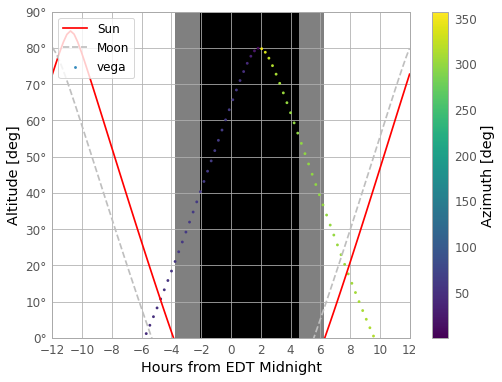

In [7]:
from astropy.visualization import astropy_mpl_style, quantity_support
plt.style.use(astropy_mpl_style)
quantity_support()

#SUN
plt.plot(delta_midnight, sun.alt, color='r', label='Sun')
#MOON
plt.plot(delta_midnight, moon.alt, color=[0.75]*3, ls='--', label='Moon')
#vega
plt.scatter(delta_midnight, source.alt,
            c= source.az, label='vega', lw=0, s=8,
            cmap='viridis')

plt.fill_between(delta_midnight, 0, 90*u.deg,
                 sun.alt < -0*u.deg, color='0.5', zorder=0)
plt.fill_between(delta_midnight, 0*u.deg, 90*u.deg,
                 sun.alt < -18*u.deg, color='k', zorder=0)
plt.colorbar().set_label('Azimuth [deg]')
plt.legend(loc='upper left')
plt.xlim(-12*u.hour, 12*u.hour)
plt.xticks((np.arange(13)*2-12)*u.hour)
plt.ylim(0*u.deg, 90*u.deg)
plt.xlabel('Hours from EDT Midnight')
plt.ylabel('Altitude [deg]')
plt.show()


## Loading config file and generating the array

In [8]:
file = open("../../layout-3AL4M15-5.txt", "r")
#array = Array()
tels = []
for line in file:  
    #split the string on whitespace, return a list of numbers as strings
    coord_str = line.split()
    coord_str[0], coord_str[1], coord_str[2] = float(coord_str[0]), float(coord_str[1]), float(coord_str[2]) 
    coord = [x*u.m for x in coord_str]
    #print(coord_float)
    tel = Telescope(coord[0],coord[1],coord[2],coord[3],coord[4])
    tels.append(tel)
    
array = Array(tels)

In [9]:
# Applying divergence to my array
np.array(array.divergent_pointing(div, array_pointing.alt, array_pointing.az));

In [10]:
#for tel in array.telescopes:
#    print(tel.id,tel.alt.to(u.deg), tel.az.to(u.deg))

In [11]:
# Do I really need this step? looks like I do ...
tels_alt = np.array([tel.alt.value for tel in array.telescopes])
tels_az = np.array([tel.az.value for tel in array.telescopes])


telescopes_distances = np.sqrt(np.sum((array.positions_array - array.barycenter)**2, axis=1))
p = np.average(array.pointing_vectors, weights=telescopes_distances, axis=0)
#print(np.degrees(p))

In [12]:
# WHY do we need this??

#tel dictionary with div pointing
tels_dict = {}
point_az_dict = {}
point_alt_dict = {}

for tel_id, tel in enumerate(array.telescopes, 1):
    
    tels_dict[tel_id] = {'az': tel.az,
                     'alt': tel.alt}
    point_az_dict[tel_id] = tel.az.value * u.rad
    point_alt_dict[tel_id] = tel.alt.value * u.rad

In [13]:
location = EarthLocation.from_geodetic('342.1184', '28.7606', 2326. * u.meter)
obstime = Time('2020-06-20T00:00',format='isot', scale='utc' ) 
altaz = AltAz(location=location, obstime=obstime)
tels_pointing = SkyCoord(alt=tels_alt,az=tels_az, frame=altaz, unit='rad')
print(tels_pointing)



<SkyCoord (AltAz: obstime=2020-06-20T00:00:00.000, location=(5327285.09211954, -1718777.11250295, 3051786.7327476) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    [(300.36345986, 64.15930101), (301.57448729, 64.56100542),
     (302.70579978, 64.18005453), (301.41872013, 63.80823627),
     (299.12023514, 64.79754987), (300.67442226, 65.45105606),
     (303.24419118, 64.92146374), (304.03674299, 63.98530921),
     (301.65634795, 63.05520584), (299.42704368, 63.56126894),
     (297.97569619, 64.05466661), (302.78030211, 65.86494981),
     (299.46559035, 62.65620636), (297.1901026 , 63.28999409),
     (301.51431003, 64.16661306), (300.32224288, 66.43324357),
     (298.32135973, 65.72569644), (296.62996592, 64.8877672 ),
     (301.63464676, 62.30939917)]>


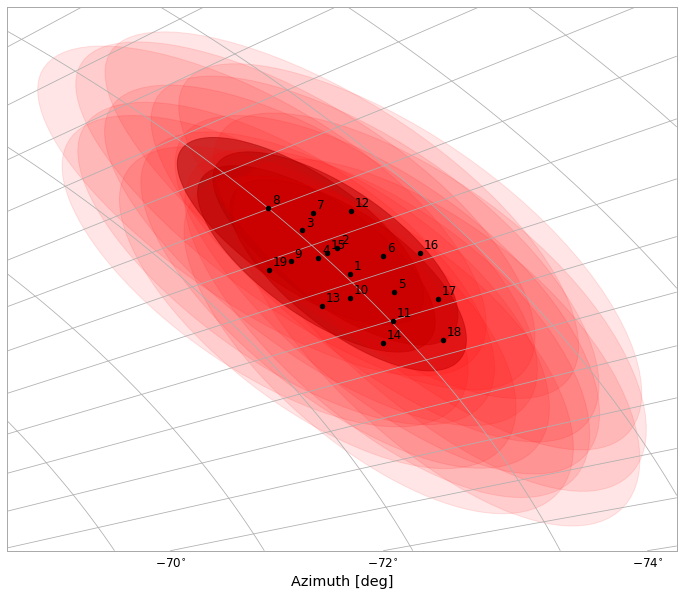

In [14]:
#WORKING
import mpl_toolkits.axisartist.angle_helper as angle_helper
from mpl_toolkits.axisartist import Subplot
from mpl_toolkits.axisartist import SubplotHost, ParasiteAxesAuxTrans
from mpl_toolkits.axisartist.grid_helper_curvelinear import GridHelperCurveLinear
from matplotlib.projections import PolarAxes
from matplotlib.transforms import Affine2D
from astropy.visualization.wcsaxes import SphericalCircle

# PolarAxes.PolarTransform takes radian. However, we want our coordinate
# system in degree
tr = Affine2D().scale(np.pi/180., 1.).translate(+np.pi/2.,0) + PolarAxes.PolarTransform()

# polar projection, which involves cycle, and also has limits in
# its coordinates, needs a special method to find the extremes
# (min, max of the coordinate within the view).

# 20, 20 : number of sampling points along x, y direction
n = 20
extreme_finder = angle_helper.ExtremeFinderCycle(10, 10,
                                                 lon_cycle=360,
                                                 lat_cycle=None,
                                                 lon_minmax=None,
                                                 lat_minmax=(-90, 90),
                                                 )

grid_locator1 = angle_helper.LocatorDMS(12)
# Find a grid values appropriate for the coordinate (degree,
# minute, second).

tick_formatter1 = angle_helper.FormatterDMS()
# And also uses an appropriate formatter.  Note that,the
# acceptable Locator and Formatter class is a bit different than
# that of mpl's, and you cannot directly use mpl's Locator and
# Formatter here (but may be possible in the future).

grid_helper = GridHelperCurveLinear(tr,
                                    extreme_finder=extreme_finder,
                                    grid_locator1=grid_locator1,
                                    tick_formatter1=tick_formatter1
                                    )

fig = plt.figure(figsize=(12,10))
fig.clf()
ax1 = SubplotHost(fig, 1, 1, 1, grid_helper=grid_helper)

# make ticklabels of right and top axis visible.
ax1.axis["right"].major_ticklabels.set_visible(False)
ax1.axis["top"].major_ticklabels.set_visible(False)
ax1.axis["bottom"].major_ticklabels.set_visible(True)

# let right axis shows ticklabels for 1st coordinate (angle)
#ax1.axis["right"].get_helper().nth_coord_ticks = 0
# let bottom axis shows ticklabels for 2nd coordinate (radius)
#ax1.axis["bottom"].get_helper().nth_coord_ticks = 1

fig.add_subplot(ax1)
# A parasite axes with given transform
ax2 = ParasiteAxesAuxTrans(ax1, tr, "equal")
# note that ax2.transData == tr + ax1.transData
# Anything you draw in ax2 will match the ticks and grids of ax1.
ax1.parasites.append(ax2)

for i, tel in enumerate(array.telescopes, 1):
    tel_alt = tel.alt
    tel_az = tel.az
    tels_points = SkyCoord(alt=tel.alt.value,az=tel.az.value, frame=altaz, unit='rad')
    x = tels_points.az.degree
    y = tels_points.alt.degree
    
    if i <= 4:
        r = SphericalCircle((x * u.deg, y * u.deg), tel.camera_radius * u.degree, color='black', alpha=0.5, transform=ax2.transData)
    else:
        r = SphericalCircle((x * u.deg, y * u.deg), tel.camera_radius * u.degree, color='r', alpha=0.1, transform=ax2.transData)

    ax1.add_patch(r)
    ax2.annotate(i, (x, y), fontsize=12, xytext=(4, 4), textcoords='offset pixels', zorder=10)
    ax1.scatter(x, y, c = "black", s=20, transform=ax2.transData, zorder=10)
    
ax1.set_aspect(1.)

ax1.grid(True)
ax1.set_xlabel("Azimuth [deg]", fontsize=20)
ax1.set_ylabel("Altitude [deg]", fontsize=20)


#plt.savefig("skymap_01.png")
plt.show()


In [15]:
from descartes import PolygonPatch
from shapely.ops import unary_union, polygonize
from shapely.geometry import mapping, Polygon, Point, LineString

polygons = {}
for ii, tel in enumerate(array.telescopes, 1):
    #print (tel.camera_radius)
  
    tel_alt = tel.alt
    tel_az = tel.az
    tels_points = SkyCoord(alt=tel.alt.value,az=tel.az.value, frame=altaz, unit='rad')
    polygons[ii-1] = Point(tels_points.az.degree, 90-tels_points.alt.degree).buffer(tel.camera_radius)

yrange = [17, 32]
xrange = [290, 310]


rings = [LineString(list(pol.exterior.coords)) for pol in polygons.values()]
union = unary_union(rings)
result = {counter:geom for counter, geom in enumerate(polygonize(union))}

ori = list(polygons.values())
res = list(result.values())


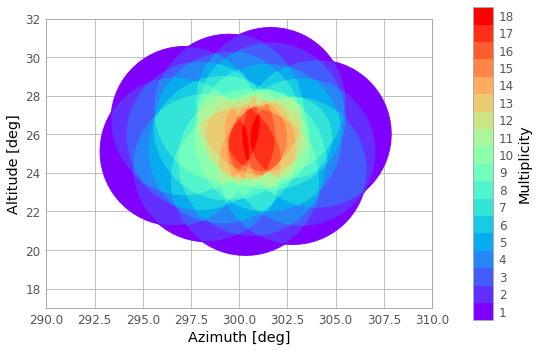

5.594986037204951 19.96847729270751 4.46861021937554
135.0078671481917


In [16]:
dict_count_overlaps = {}
for i in range(len(res)):
    dict_count_overlaps[i] = 0
    
    for j in range(len(ori)):
        if np.isclose(res[i].difference(ori[j]).area, 0):      
            dict_count_overlaps[i] +=1
            

max_multiplicity = max(dict_count_overlaps.values())
#print(max_multiplicity)

cmap = plt.cm.get_cmap('rainbow')
color_list = cmap(np.linspace(0, 1, max_multiplicity))
bounds = np.arange(max_multiplicity + 1) + 1

fig = plt.figure()
gs  = mpl.gridspec.GridSpec(1, 2, width_ratios=[0.95, 0.05])

ax = plt.subplot(gs[0])
ax_cb = plt.subplot(gs[1])

fig.subplots_adjust(top=0.85)

for pol_id, pol in result.items():
    #print(pol_id,pol)
    colore = dict_count_overlaps[pol_id]
    #print(colore)
    ax.add_patch(
         PolygonPatch(mapping(pol), color=color_list[colore-1])
    )

norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

cb1 = mpl.colorbar.ColorbarBase(ax_cb,
                                 norm=norm,
                                 cmap=cmap,
                                 boundaries = bounds,
                                 orientation='vertical',
                                label='Multiplicity')
cb1.set_ticks(np.arange(max_multiplicity + 1) + 0.5)
cb1.set_ticklabels(np.arange(max_multiplicity + 1) + 1)

ax.set_xlabel("Azimuth [deg]")
ax.set_ylabel("Altitude [deg]")
ax.set_xlim(*xrange)
ax.set_ylim(*yrange)
ax.set_aspect(1)
#plt.savefig("multiplicity_plot_div{}.png".format(div))
plt.show()

hfov = []
for patchsky in res:
     hfov.append(patchsky.area)
     #print(patchsky.area)

hfov = np.array(hfov) #hfov è generato come lista e viene qui convertito in array
# multiplicity associated with each patch
overlaps = np.array(list(dict_count_overlaps.values()))
average_overlap = np.average(overlaps, weights=hfov)
variance = np.average((overlaps-average_overlap)**2, weights=hfov)
print(average_overlap, variance, np.sqrt(variance))
print(hfov.sum())


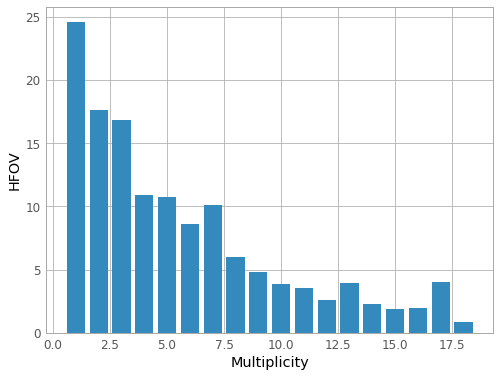

In [17]:
plt.figure()
plt.bar(list(set(overlaps)), [hfov[overlaps==i].sum() for i in set(overlaps)])
plt.ylabel('HFOV')
plt.xlabel('Multiplicity')
#plt.savefig("multiplicity_chart_div{}.png".format(div))
plt.show()


## Evolving object position through time

This sections starts from the assumption that we are allowed to track the initial pointing position for each telescope. Pointing positions are converted to RaDec and the new positions in AltAz are computed for the same location and a time defined as obstime + 20min (could have been whatever value, I took 20 minutes because is the standard time used for 1 whobble position)

(This does not mean we are wobbling, would be premature to tink about it right now. I just needed a reference time)

In [18]:
# Converting telescope pointings in RaDec
tels_pointing_radec=tels_pointing.transform_to(ICRS())
tels_pointing_radec

<SkyCoord (ICRS): (ra, dec) in deg
    [(221.73809175, 38.85021945), (222.411303  , 39.25343465),
     (222.11217079, 39.8290317 ), (221.44956786, 39.38625107),
     (222.36741206, 38.17814505), (223.38282022, 38.6485729 ),
     (223.12346631, 39.83294788), (222.09198213, 40.44224249),
     (220.54025791, 39.68028279), (220.86978304, 38.58794118),
     (221.31075718, 37.85741612), (224.21318393, 39.36143198),
     (219.74214238, 38.79946783), (220.27708691, 37.6619865 ),
     (221.91119277, 39.33346533), (224.54100435, 38.24554396),
     (223.41397551, 37.63846307), (222.19577514, 37.12453772),
     (219.59656641, 39.85379706)]>

In [19]:
# Defining my new reference time and ref frame for AltAz
t_end=obstime + 20*u.min
t_end = Time(t_end,  format='isot', scale='utc')
new_frame=AltAz(obstime=t_end, location=location)

In [20]:
#Computing new pointings for evolved time position
new_tels_pointing = tels_pointing_radec.transform_to(AltAz(obstime=t_end, location=location))
print(new_tels_pointing)

<SkyCoord (AltAz: obstime=2020-06-20T00:20:00.000, location=(5327285.09211954, -1718777.11250295, 3051786.7327476) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    [(298.66002969, 60.33172814), (299.65445638, 60.77554253),
     (300.71442607, 60.43799589), (299.64536684, 60.01973724),
     (297.4669266 , 60.92487672), (298.71065177, 61.63001207),
     (301.05276373, 61.19693573), (301.92100229, 60.29516978),
     (299.97724891, 59.27796265), (297.93190392, 59.70289842),
     (296.58230405, 60.14602022), (300.46713757, 62.11899279),
     (298.10120971, 58.801815  ), (296.00375482, 59.35787881),
     (299.66940125, 60.38035992), (298.22399902, 62.59618996),
     (296.61674818, 61.82338602), (295.28040232, 60.93368395),
     (300.07428251, 58.53377457)]>


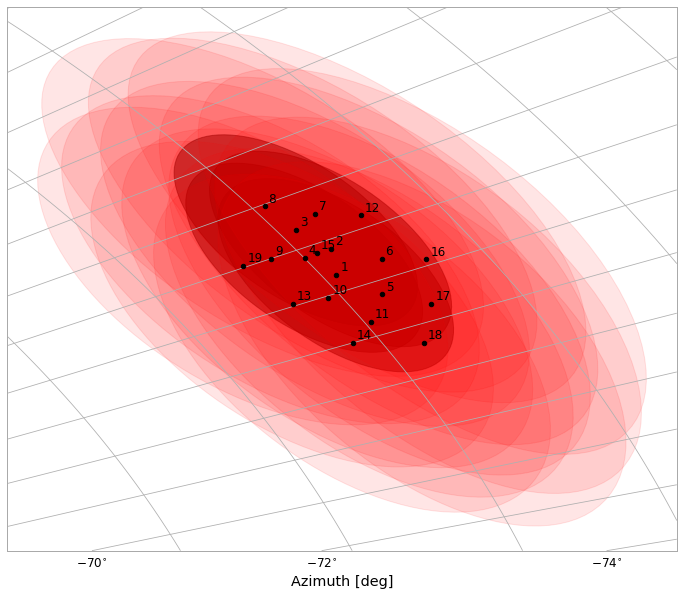

In [21]:
# Reproducing previous plots for the new position
#(in the ipothesys we have been tracking initial positions for 20 min

fig = plt.figure(figsize=(12,10))
fig.clf()
ax1 = SubplotHost(fig, 1, 1, 1, grid_helper=grid_helper)


ax1.axis["right"].major_ticklabels.set_visible(False)
ax1.axis["top"].major_ticklabels.set_visible(False)
ax1.axis["bottom"].major_ticklabels.set_visible(True)


fig.add_subplot(ax1)

ax2 = ParasiteAxesAuxTrans(ax1, tr, "equal")

ax1.parasites.append(ax2)

for i, tel in enumerate(array.telescopes, 1):
    tel_alt = new_tels_pointing[i-1].alt.to(u.rad)
    tel_az = new_tels_pointing[i-1].az.to(u.rad)
    tels_points = SkyCoord(alt=tel_alt.value,az=tel_az.value, frame=new_frame, unit='rad')
    x = tels_points.az.degree
    y = tels_points.alt.degree

    if i <= 4:
        r = SphericalCircle((x * u.deg, y * u.deg), tel.camera_radius * u.degree, color='black', alpha=0.5, transform=ax2.transData)
    else:
        r = SphericalCircle((x * u.deg, y * u.deg), tel.camera_radius * u.degree, color='r', alpha=0.1, transform=ax2.transData)

    ax1.add_patch(r)
    ax2.annotate(i, (x, y), fontsize=12, xytext=(4, 4), textcoords='offset pixels', zorder=10)
    ax1.scatter(x, y, c = "black", s=20, transform=ax2.transData, zorder=10)


ax1.set_aspect(1.)

ax1.grid(True)
ax1.set_xlabel("Azimuth [deg]", fontsize=20)
ax1.set_ylabel("Altitude [deg]", fontsize=20)

plt.savefig("skymap_tracking.png")
plt.show()


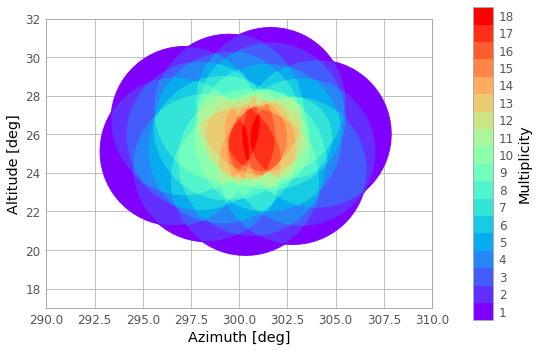

5.594986037204951 19.96847729270751 4.46861021937554
135.0078671481917


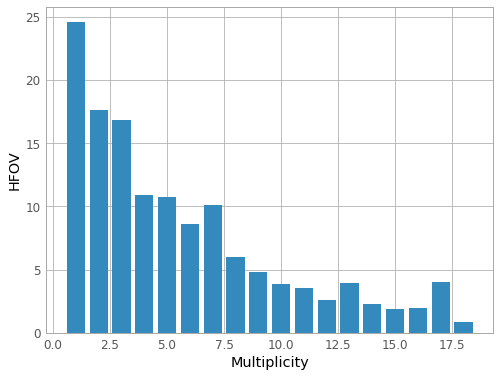

In [22]:
polygons = {}
for ii, tel in enumerate(array.telescopes, 1):
   
        tel_alt = new_tels_pointing[ii-1].alt.to(u.rad)
        tel_az = new_tels_pointing[ii-1].az.to(u.rad)
        
        tels_points = SkyCoord(alt=tel.alt.value,az=tel.az.value, frame=new_frame, unit='rad')
        polygons[ii-1] = Point(tels_points.az.degree, 90-tels_points.alt.degree).buffer(tel.camera_radius)

#xrange = [50, 70]
#yrange = [22, 37]

rings = [LineString(list(pol.exterior.coords)) for pol in polygons.values()]
union = unary_union(rings)
result = {counter:geom for counter, geom in enumerate(polygonize(union))}

ori = list(polygons.values())
res = list(result.values())

dict_count_overlaps = {}
for i in range(len(res)):
    dict_count_overlaps[i] = 0
    for j in range(len(ori)):
         if np.isclose(res[i].difference(ori[j]).area, 0):
            dict_count_overlaps[i] +=1
             #print(f"res_{colors[i]}, orig_{j+1}")


max_multiplicity = max(dict_count_overlaps.values())
#print(max_multiplicity)

cmap = plt.cm.get_cmap('rainbow')
color_list = cmap(np.linspace(0, 1, max_multiplicity))
bounds = np.arange(max_multiplicity + 1) + 1

fig = plt.figure()
gs  = mpl.gridspec.GridSpec(1, 2, width_ratios=[0.95, 0.05])

ax = plt.subplot(gs[0])
ax_cb = plt.subplot(gs[1])

fig.subplots_adjust(top=0.85)

for pol_id, pol in result.items():

    colore = dict_count_overlaps[pol_id]
    ax.add_patch(
         PolygonPatch(mapping(pol), color=color_list[colore-1])
     )

norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

cb1 = mpl.colorbar.ColorbarBase(ax_cb,
                                 norm=norm,
                                 cmap=cmap,
                                 boundaries = bounds,
                                 orientation='vertical',
                                label='Multiplicity')
cb1.set_ticks(np.arange(max_multiplicity + 1) + 0.5)
cb1.set_ticklabels(np.arange(max_multiplicity + 1) + 1)

ax.set_xlabel("Azimuth [deg]")
ax.set_ylabel("Altitude [deg]")
ax.set_xlim(*xrange)
ax.set_ylim(*yrange)
ax.set_aspect(1)
plt.savefig("multiplicity_01.png")
plt.show()

hfov = []
for patchsky in res:
     hfov.append(patchsky.area)
     #print(patchsky.area)

hfov = np.array(hfov)
# multiplicity associated with each patch
overlaps = np.array(list(dict_count_overlaps.values()))
average_overlap = np.average(overlaps, weights=hfov)
variance = np.average((overlaps-average_overlap)**2, weights=hfov)
print(average_overlap, variance, np.sqrt(variance))
print(hfov.sum())
plt.figure()
plt.bar(list(set(overlaps)), [hfov[overlaps==i].sum() for i in set(overlaps)])
plt.ylabel('HFOV')
plt.xlabel('Multiplicity')
plt.savefig("multiplicity_chart_01.png")
plt.show()

Assuming that my code is correct you can see that the FoV stays the same as the begginning. This is reasonable according to our hypotesis on telescope motion. We are tracking a set of positions on the sky which are moving coherently

## Evolving the source position 
This time we trie to evolve the source position and compute telescopes pointing directions and FoV for this new position

In [23]:
# Array pointing direction in AltAz frame
new_pointing = source_altaz(pointing_dir,'2020-06-20T00:20','Roque de los Muchachos')
#az = array_pointing.az
#alt = array_pointing.alt
print (f'alt:{array_pointing.alt} , az:{array_pointing.az}')
print (f'zd: {90*u.deg-array_pointing.alt}')


alt:64.31210302378614 deg , az:59.475204502353606 deg
zd: 25.687896976213864 deg


In [24]:
file = open("../layout-3AL4M15-5.txt", "r")
#array = Array()
Tels = []
for line in file:  
    #split the string on whitespace, return a list of numbers as strings
    coord_str = line.split()
    coord_str[0], coord_str[1], coord_str[2] = float(coord_str[0]), float(coord_str[1]), float(coord_str[2]) 
    coord = [x*u.m for x in coord_str]
    #print(coord_float)
    Tel = Telescope(coord[0],coord[1],coord[2],coord[3],coord[4])
    Tels.append(Tel)
    
array = Array(Tels)

In [25]:
# Applying divergence to my array
np.array(array.divergent_pointing(div, new_pointing.alt, new_pointing.az));

In [26]:
# Do I really need this step? looks like I do ...
tels_alt = np.array([tel.alt.value for tel in array.telescopes])
tels_az = np.array([tel.az.value for tel in array.telescopes])


telescopes_distances = np.sqrt(np.sum((array.positions_array - array.barycenter)**2, axis=1))
p = np.average(array.pointing_vectors, weights=telescopes_distances, axis=0)
#print(np.degrees(p))

# WHY do we need this??

#tel dictionary with div pointing
tels_dict = {}
point_az_dict = {}
point_alt_dict = {}

for tel_id, tel in enumerate(array.telescopes, 1):
    
    tels_dict[tel_id] = {'az': tel.az,
                     'alt': tel.alt}
    point_az_dict[tel_id] = tel.az.value * u.rad
    point_alt_dict[tel_id] = tel.alt.value * u.rad
    
tels_pointing = SkyCoord(alt=tels_alt,az=tels_az, frame=altaz, unit='rad')

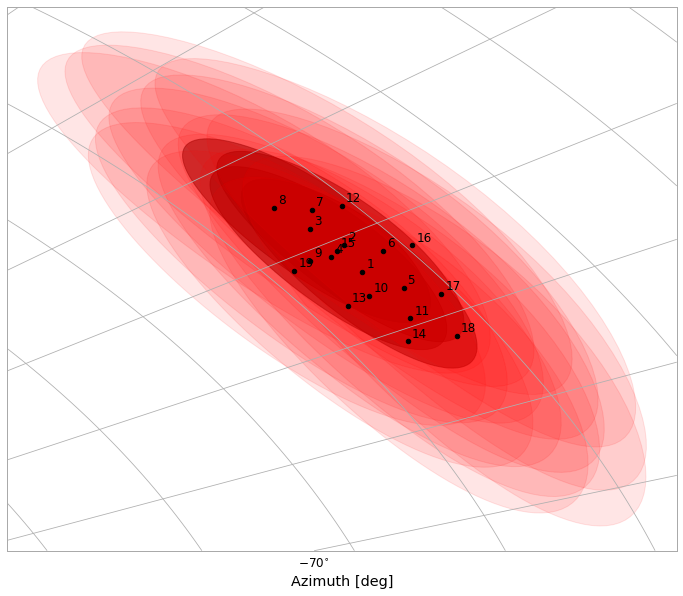

In [27]:
# PolarAxes.PolarTransform takes radian. However, we want our coordinate
# system in degree
tr = Affine2D().scale(np.pi/180., 1.).translate(+np.pi/2.,0) + PolarAxes.PolarTransform()

# polar projection, which involves cycle, and also has limits in
# its coordinates, needs a special method to find the extremes
# (min, max of the coordinate within the view).

# 20, 20 : number of sampling points along x, y direction
n = 20
extreme_finder = angle_helper.ExtremeFinderCycle(10, 10,
                                                 lon_cycle=360,
                                                 lat_cycle=None,
                                                 lon_minmax=None,
                                                 lat_minmax=(-90, 90),
                                                 )

grid_locator1 = angle_helper.LocatorDMS(12)
# Find a grid values appropriate for the coordinate (degree,
# minute, second).

tick_formatter1 = angle_helper.FormatterDMS()
# And also uses an appropriate formatter.  Note that,the
# acceptable Locator and Formatter class is a bit different than
# that of mpl's, and you cannot directly use mpl's Locator and
# Formatter here (but may be possible in the future).

grid_helper = GridHelperCurveLinear(tr,
                                    extreme_finder=extreme_finder,
                                    grid_locator1=grid_locator1,
                                    tick_formatter1=tick_formatter1
                                    )

fig = plt.figure(figsize=(12,10))
fig.clf()
ax1 = SubplotHost(fig, 1, 1, 1, grid_helper=grid_helper)

# make ticklabels of right and top axis visible.
ax1.axis["right"].major_ticklabels.set_visible(False)
ax1.axis["top"].major_ticklabels.set_visible(False)
ax1.axis["bottom"].major_ticklabels.set_visible(True)

# let right axis shows ticklabels for 1st coordinate (angle)
#ax1.axis["right"].get_helper().nth_coord_ticks = 0
# let bottom axis shows ticklabels for 2nd coordinate (radius)
#ax1.axis["bottom"].get_helper().nth_coord_ticks = 1

fig.add_subplot(ax1)
# A parasite axes with given transform
ax2 = ParasiteAxesAuxTrans(ax1, tr, "equal")
# note that ax2.transData == tr + ax1.transData
# Anything you draw in ax2 will match the ticks and grids of ax1.
ax1.parasites.append(ax2)

for i, tel in enumerate(array.telescopes, 1):
    tel_alt = tel.alt
    tel_az = tel.az
    tels_points = SkyCoord(alt=tel.alt.value,az=tel.az.value, frame=altaz, unit='rad')
    x = tels_points.az.degree
    y = tels_points.alt.degree
    
    if i <= 4:
        r = SphericalCircle((x * u.deg, y * u.deg), tel.camera_radius * u.degree, color='black', alpha=0.5, transform=ax2.transData)
    else:
        r = SphericalCircle((x * u.deg, y * u.deg), tel.camera_radius * u.degree, color='r', alpha=0.1, transform=ax2.transData)

    ax1.add_patch(r)
    ax2.annotate(i, (x, y), fontsize=12, xytext=(4, 4), textcoords='offset pixels', zorder=10)
    ax1.scatter(x, y, c = "black", s=20, transform=ax2.transData, zorder=10)
    
ax1.set_aspect(1.)

ax1.grid(True)
ax1.set_xlabel("Azimuth [deg]", fontsize=20)
ax1.set_ylabel("Altitude [deg]", fontsize=20)


#plt.savefig("skymap_01.png")
plt.show()

In [28]:
polygons = {}
for ii, tel in enumerate(array.telescopes, 1):
    #print (tel.camera_radius)
  
    tel_alt = tel.alt
    tel_az = tel.az
    tels_points = SkyCoord(alt=tel.alt.value,az=tel.az.value, frame=altaz, unit='rad')
    polygons[ii-1] = Point(tels_points.az.degree, 90-tels_points.alt.degree).buffer(tel.camera_radius)

yrange = [13, 30]
xrange = [295, 312]


rings = [LineString(list(pol.exterior.coords)) for pol in polygons.values()]
union = unary_union(rings)
result = {counter:geom for counter, geom in enumerate(polygonize(union))}

ori = list(polygons.values())
res = list(result.values())


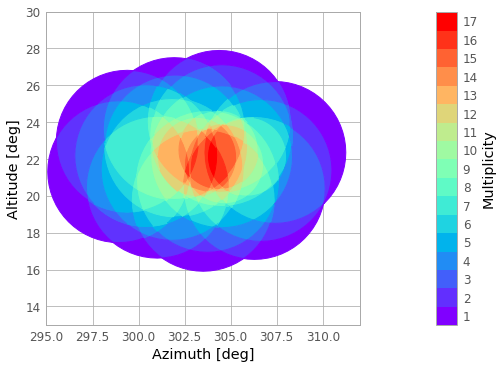

5.1267428189442965 16.335242910446627 4.041688126321306
147.33860431144063


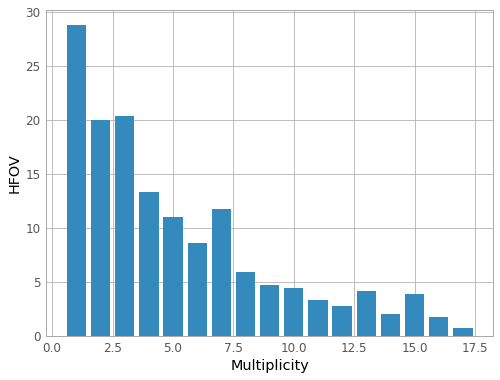

In [29]:
dict_count_overlaps = {}
for i in range(len(res)):
    dict_count_overlaps[i] = 0
    for j in range(len(ori)):
         if np.isclose(res[i].difference(ori[j]).area, 0):
            dict_count_overlaps[i] +=1
             #print(f"res_{colors[i]}, orig_{j+1}")


max_multiplicity = max(dict_count_overlaps.values())
#print(max_multiplicity)

cmap = plt.cm.get_cmap('rainbow')
color_list = cmap(np.linspace(0, 1, max_multiplicity))
bounds = np.arange(max_multiplicity + 1) + 1

fig = plt.figure()
gs  = mpl.gridspec.GridSpec(1, 2, width_ratios=[0.95, 0.05])

ax = plt.subplot(gs[0])
ax_cb = plt.subplot(gs[1])

fig.subplots_adjust(top=0.85)

for pol_id, pol in result.items():

    colore = dict_count_overlaps[pol_id]
    ax.add_patch(
         PolygonPatch(mapping(pol), color=color_list[colore-1])
     )

norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

cb1 = mpl.colorbar.ColorbarBase(ax_cb,
                                 norm=norm,
                                 cmap=cmap,
                                 boundaries = bounds,
                                 orientation='vertical',
                                label='Multiplicity')
cb1.set_ticks(np.arange(max_multiplicity + 1) + 0.5)
cb1.set_ticklabels(np.arange(max_multiplicity + 1) + 1)

ax.set_xlabel("Azimuth [deg]")
ax.set_ylabel("Altitude [deg]")
ax.set_xlim(*xrange)
ax.set_ylim(*yrange)
ax.set_aspect(1)
plt.savefig("multiplicity_01.png")
plt.show()

hfov = []
for patchsky in res:
     hfov.append(patchsky.area)
     #print(patchsky.area)

hfov = np.array(hfov)
# multiplicity associated with each patch
overlaps = np.array(list(dict_count_overlaps.values()))
average_overlap = np.average(overlaps, weights=hfov)
variance = np.average((overlaps-average_overlap)**2, weights=hfov)
print(average_overlap, variance, np.sqrt(variance))
print(hfov.sum())
plt.figure()
plt.bar(list(set(overlaps)), [hfov[overlaps==i].sum() for i in set(overlaps)])
plt.ylabel('HFOV')
plt.xlabel('Multiplicity')
plt.savefig("multiplicity_chart_01.png")
plt.show()

In this second case we get a greater FoV. This means that if we track each single initial pointing we mantain the FoV defined from divergence applied to initial position. (differen from 'istantaneous FoV' defined by divergent for the tracked source)

## Summary

The goal of this notebook was to illustrate the problem we are facing when we want to track a source. 
There are now set of open questions:
- Are were really able to make each telescope track a different position (from drive PoV)?
- Is there a smart way to tell the array to track the source adjusting divergent to source position without passing G to the array each few minutes/seconds? (not allowed by drive)
- At small zenith we loose multiplicity. What do we do when sources are in that position? (we must chose div in a smart way, here I just made some tests with a dummy value)
- ...

## Next steps

- Test the behaviour of more sources at different alt_az positions
- Test the behaviour of sources on longer time-scales
- Repeat tests for different div values
- (Transform this notebook into a script allowing to customize tests and run them in a fast way)